<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков." data-toc-modified-id="Создание-признаков.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Создание признаков.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
! pip install lightgbm -q
! pip install joblib -q
! pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

In [3]:
RS = 42

In [4]:
pth = '/datasets/taxi.csv'

try:
    df = pd.read_csv(pth, index_col=[0], parse_dates=[0])
except FileNotFoundError:
    print('Файл не найден. Загрузка не удалась.')
except Exception as e:
    print(f'Произошла ошибка при загрузке файла: {e}')

In [5]:
df.sample(3)

,num_orders
datetime,
2018-07-26 20:30:00,10
2018-07-11 19:00:00,7
2018-05-09 20:30:00,15


In [6]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [7]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Импорт - успешен. 4416 строк данных на месте. Начнем анализ, мы уже ресемплировали данные по 1 часу, возьмем скользящее среднее =24.

## Анализ

In [9]:
df.duplicated().sum()

4165

In [10]:
rolling_mean = df['num_orders'].rolling(24).mean()  
rolling_std = df['num_orders'].rolling(24).std()  

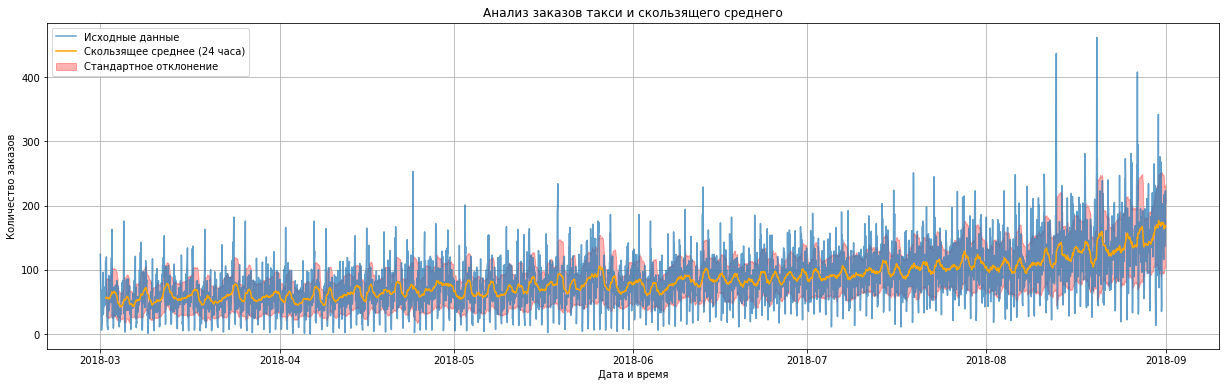

In [11]:
plt.figure(figsize=(21, 6))
plt.plot(df.index, df['num_orders'], label='Исходные данные', alpha=0.7)
plt.plot(rolling_mean.index, rolling_mean, label='Скользящее среднее (24 часа)', color='orange')
plt.fill_between(rolling_std.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color='red', alpha=0.3,
                 label='Стандартное отклонение')
plt.title('Анализ заказов такси и скользящего среднего')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.show()

Можно заметить, что среднее количество заказов увеличивается с течением времени.

In [12]:
decomposition = sm.tsa.seasonal_decompose(df['num_orders'], model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal

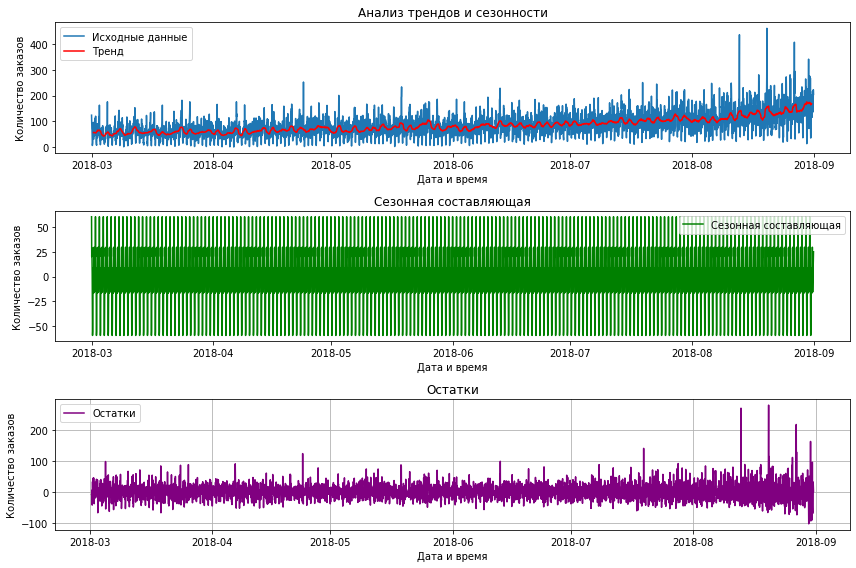

Тест Дики-Фуллера:
ADF статистика: -19.571753340784692
p-value: 0.0
Критические значения:
   1%: -3.4318500349402785
   5%: -2.8622028319028052
   10%: -2.5671228298878166
None


In [13]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(df.index, df['num_orders'], label='Исходные данные')
plt.plot(trend.index, trend, label='Тренд', color='red')
plt.title('Анализ трендов и сезонности')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()

plt.subplot(312)
plt.plot(seasonal.index, seasonal, label='Сезонная составляющая', color='green')
plt.title('Сезонная составляющая')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()

plt.subplot(313)
plt.plot(df.index, df['num_orders'] - trend - seasonal, label='Остатки', color='purple')
plt.title('Остатки')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

def test_stationarity(timeseries):
    result = adfuller(timeseries.values, autolag='AIC')
    print('Тест Дики-Фуллера:')
    print('ADF статистика:', result[0])
    print('p-value:', result[1])
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

residuals = df['num_orders'] - trend - seasonal

print (test_stationarity(residuals.dropna()))


Можно видеть увеличение числа заказов со временем. Сезонность так же наблюдается, возможно выходного дня. Результаты теста Дики-Фуллера указывают на то, что временной ряд стационарен. Это подтверждается значением p-value, которое равно 0.0 (меньше уровня значимости 0.05), и ADF статистикой, которая значительно меньше критических значений при всех уровнях значимости (1%, 5%, 10%).

### Создание признаков.

Год не меняется, создадим признаки месяц, день, час + лаги. Окно скользящего среднего возьмем как среднее за последний день (24) и среднее за последнюю неделю(168). 

In [14]:
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['day'] = df.index.day
df['hour'] = df.index.hour

In [15]:
df['rolling_mean_24'] = df['num_orders'].shift().rolling(window=24).mean()
df['rolling_mean_168'] = df['num_orders'].shift().rolling(window=168).mean()

In [16]:
df['lag_24'] = df['num_orders'].shift(24)
df['lag_168'] = df['num_orders'].shift(168)

In [17]:
df.dropna(inplace=True)

In [18]:
df.sample(3)

,num_orders,month,day_of_week,day,hour,rolling_mean_24,rolling_mean_168,lag_24,lag_168
datetime,,,,,,,,,
2018-08-12 17:00:00,115,8,6,12,17,108.916667,110.821429,122.0,124.0
2018-08-28 18:00:00,113,8,1,28,18,139.666667,140.333333,111.0,94.0
2018-07-24 09:00:00,114,7,1,24,9,106.750000,102.851190,152.0,108.0


In [19]:
X = df.drop('num_orders', axis = 1)
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RS)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print (y_test.shape)

(3823, 8)
(425, 8)
(3823,)
(425,)


## Обучение

In [21]:
pipelines = {
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=RS))
    ]),
    'LGBM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LGBMRegressor(random_state=RS))
    ]),
    'CatBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('model', CatBoostRegressor(random_state=RS, verbose=0))
    ])
}

In [22]:
param_grids = {
    'RandomForest': {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [5, 10, 15],
        'model__min_samples_split': [2, 5, 10]
    },
    'LGBM': {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [5, 10, 15],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'CatBoost': {
        'model__iterations': [50, 100, 150],
        'model__depth': [5, 10, 15],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

In [23]:
best_models = {}
best_rmse = float('inf')
best_params = {}

tscv = TimeSeriesSplit(n_splits=5)  

for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    rmse = sqrt(-grid_search.best_score_)
    if rmse < best_rmse:
        best_rmse = rmse
        best_models[model_name] = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_

best_model_name = min(best_params, key=lambda x: best_rmse)
joblib.dump(best_models[best_model_name], 'best_model.pkl')
print(f'Лучшая модель: {best_model_name}, лучшие параметры: {best_params[best_model_name]}, RMSE на трейне: {best_rmse}')

Лучшая модель: RandomForest, лучшие параметры: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 150}, RMSE на трейне: 4.873106815007412


## Тестирование

In [24]:
loaded_model = joblib.load('best_model.pkl')
predictions = loaded_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print('RMSE лучшей модели на тесте:', rmse)

RMSE лучшей модели на тесте: 23.196803751984373


In [25]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print('RMSE по предыдущему значению ряда:', mean_squared_error(y_test, pred_previous, squared=False))

RMSE по предыдущему значению ряда: 60.80739119160936


In [26]:
pred_median = np.ones(y_test.shape) * y_train.median()
print('RMSE константа:', mean_squared_error(y_test, pred_median, squared=False))

RMSE константа: 43.249454263812936


#### Вывод: 
Данные качественные, выгрузились без проблем. Дубликаты, пропуски, артефакты - не встретились. Но дф совсем не большой. Скользящее среднее взяли 24 часа. При анализе наблюдается общее плавное увеличение колличества заказов со временем. Есть сезонность. Тест Дики-Фулера определил временной ряд как стаионарный. Добавили признаки: месяц, день, день недели, час, а так же скользящее среднее по 24 и 168 часам + соотвествующие лаги. Признаки масштабировали StandartScaler. Модели: RandomForest, CatBoost, LGBM. Перебор гиперпараметров + кросс валидация GrindsearchCV. По итогу лучшая модель - RandomForest с параметрами: max_depth: 10, min_samples_split: 10, n_estimators: 150 и RMSE на тестовой выборке 23.1, RMSE по предыдущему значению ряда: 60.80739119160936, RMSE константа: 43.249454263812936. Модель адекватно предсказывает. RMSE < 48. тз выполнено. 